## What I'm aiming to do

- Merge the Store/training data together
- Understand the time structure of the data
- Give about 50% of the times to the training of the model and then leave the rest for real life situations

## TODO

- Models changing vs new data being included. KS test?
- Time series splitter?
    + So I could build three time based train/test splits
    + Need to order the data by date to use this functionality.
- What features can you use?
    + How dodgy time series features can be problematic
- Model UAT? Traffic light

In [35]:
%matplotlib inline

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder

In [2]:
store = pd.read_csv('../data/store.csv')
train = pd.read_csv('../data/train.csv')

C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
store.head().T

,0,1,2,3,4
Store,1,2,3,4,5
StoreType,c,a,a,c,a
Assortment,a,a,a,c,a
CompetitionDistance,1270,570,14130,620,29910
CompetitionOpenSinceMonth,9,11,12,9,4
CompetitionOpenSinceYear,2008,2007,2006,2009,2015
Promo2,0,1,1,0,0
Promo2SinceWeek,NaN,13,14,NaN,NaN
Promo2SinceYear,NaN,2010,2011,NaN,NaN
PromoInterval,NaN,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",NaN,NaN


In [4]:
train.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1


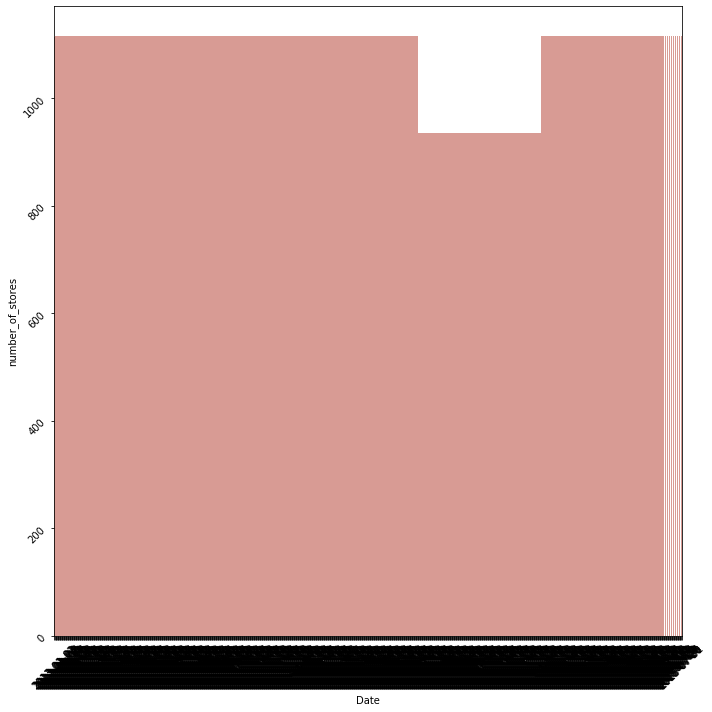

In [5]:
grp_df = train.groupby('Date')['Store'].nunique().reset_index()
grp_df = grp_df.rename(columns={'Store': 'number_of_stores'})

fig, ax = plt.subplots(1, figsize=(10, 10))

sns.barplot(x="Date", y="number_of_stores", data=grp_df,
                  color="salmon", saturation=.5, ax=ax)
ax.tick_params(labelrotation=45)
plt.tight_layout()

## Tidy up the above figure so we can see the x axis labels

So now we can see that there a few stores that we don't have data for a period of time. We'll want to drop those stores

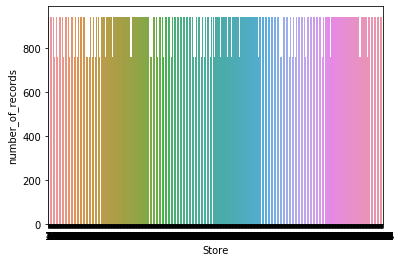

In [6]:
grp_df = train.groupby('Store')['Date'].nunique().reset_index()
grp_df = grp_df.rename(columns={'Date': 'number_of_records'})
sns.barplot(x='Store', y='number_of_records', data=grp_df)

In [7]:
train['store_date_records'] = train.groupby('Store')['Date'].transform('nunique')
print(train['Store'].nunique())
print(train['store_date_records'].value_counts())

train_subset = train.loc[train['store_date_records'] == train['store_date_records'].max(), :]
print(train_subset['Store'].nunique())

1115
942    879828
758    136440
941       941
Name: store_date_records, dtype: int64
934


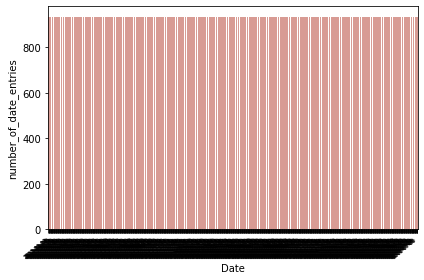

In [8]:
grp_df = train_subset.groupby('Date')['Store'].nunique().reset_index()
grp_df = grp_df.rename(columns={'Store': 'number_of_date_entries'})

ax = sns.barplot(x="Date", y="number_of_date_entries", data=grp_df,
                  color="salmon", saturation=.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=5)
plt.tight_layout()
plt.show()

In [9]:
print(train_subset['Date'].min())
print(train_subset['Date'].max())

2013-01-01
2015-07-31


So every date record that happens before this date will be included in the model build process. Every date after will be incrementaly added to train to replicate real life

In [10]:
train_subset['initial_build_set'] = train_subset['Date'] < '2014-12-31' 

C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
train_subset.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1
store_date_records,942,942,942,942,942


In [12]:
model_superset = train_subset.merge(store, on='Store')
model_superset.head().T

,0,1,2,3,4
Store,1,1,1,1,1
DayOfWeek,5,4,3,2,1
Date,2015-07-31,2015-07-30,2015-07-29,2015-07-28,2015-07-27
Sales,5263,5020,4782,5011,6102
Customers,555,546,523,560,612
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1
store_date_records,942,942,942,942,942


In [13]:
model_set = model_superset.loc[model_superset['initial_build_set'] == True, :]
model_deploy_set = model_superset.loc[model_superset['initial_build_set'] == False, :]

In [14]:
model_set.head().T

,213,214,215,216,217
Store,1,1,1,1,1
DayOfWeek,2,1,7,6,5
Date,2014-12-30,2014-12-29,2014-12-28,2014-12-27,2014-12-26
Sales,6466,6463,0,6057,0
Customers,703,700,0,684,0
Open,1,1,0,1,0
Promo,0,0,0,0,0
StateHoliday,0,0,0,0,c
SchoolHoliday,1,1,1,1,1
store_date_records,942,942,942,942,942


## Train data until 2014-09-30
## Test data from 2014-10-01 to 2014-12-31

We need to think about data we'll have at prediction time

- Can't include customers as we wouldn't know that ahead of time
- Will need to assume that we know of Promos atleast the max prediction window ahead of time
- I'm just gonna deal with the easy to work with variables

In [17]:
https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

from pandas import Series

from matplotlib import pyplot
series = Series.from_csv('sunspots.csv', header=0)
X = series.values
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    pyplot.subplot(310 + index)
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    index += 1
pyplot.show()

Want to visualize which days are being put in to train/test

SyntaxError: invalid syntax (<ipython-input-17-bbd74245f4b0>, line 21)

## There might be time overhang with one or two stores being put into the wrong fold but until groupwise time splits are avaiable there ain't much to do

In [74]:
model_set = model_set.sort_values('Date', ascending=True)

modelling_cols = ['DayOfWeek', 
                  'Open', 
                  'Promo', 
                  'StoreType',
                  'Assortment',
                  'CompetitionDistance',
                  'CompetitionOpenSinceMonth',
                 ]

y = model_set['Sales']
X = model_set[modelling_cols]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
X.head().T

,439913,876059,875117,874175,873233
DayOfWeek,2,2,2,2,2
Open,0,0,0,0,0
Promo,0,0,0,0,0
StoreType,a,a,c,a,a
Assortment,a,a,c,a,c
CompetitionDistance,3000,1900,900,540,5330
CompetitionOpenSinceMonth,2,6,9,4,9


In [32]:
# X['CompetitionOpenSinceYear'].value_counts().reset_index()['index'].values

array([2013., 2012., 2014., 2010., 2005., 2011., 2009., 2008., 2007.,
       2006., 2015., 2002., 2004., 2001., 2003., 2000., 1999., 1990.,
       1994., 1998., 1995., 1961.])

In [64]:
import numpy as np

# X['StateHoliday'].value_counts().reset_index()['index'].values
# X['StateHoliday'] = X['StateHoliday'].replace(0, np.nan)
# X['StateHoliday'] = X['StateHoliday'].replace(0, np.nan)
# X['CompetitionOpenSinceYear'] = X['CompetitionOpenSinceYear'].astype(str)

C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [73]:
X['StateHoliday'].value_counts().reset_index()['index'].values

array(['0', 'a', 'c', 'b'], dtype=object)

In [80]:
X.isnull().mean()

DayOfWeek                    0.000000
Open                         0.000000
Promo                        0.000000
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002141
CompetitionOpenSinceMonth    0.320128
dtype: float64

In [81]:
# Gonna treat competitionOpenSinceYear as a categorical - this could cause issues when new establishment years are brought through.
# But I don't know 
cats_vars = ['StoreType', 'Assortment']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

binary_vars = ['Open', 'Promo']
numeric_cols = ['CompetitionDistance', 'CompetitionOpenSinceMonth']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('bins', KBinsDiscretizer(n_bins=10))#,
#     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cats_vars)],
    remainder='passthrough',
    sparse_threshold=0)
        
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('reg', HistGradientBoostingRegressor())])

clf.fit(X_train, y_train)

C:\Users\evanm\Anaconda3\envs\rm_models\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0, transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=0,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                                                 verbose=0))